In [11]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [12]:
dataset_path = 'sentiment_analysis.csv'
df = pd.read_csv(   
    filepath_or_buffer=dataset_path,
    index_col='id'
)
df.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


In [13]:
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r'^RT [\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Hashtags removal
    text = text.replace('#', '')

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)

    return text_tokens

In [14]:
def get_freqs(df) :
    freqs = defaultdict(lambda : 0)
    for _, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']

        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1

    return freqs

In [15]:
def get_feature(text, freqs) :
    tokens = text_normalize(text)

    x = np.zeros(3)
    x[0] = 1

    for token in tokens :
        x[1] += freqs[(token, 0)]
        x[2] += freqs[(token, 1)]

    return x

In [16]:
x = []
y = []
freqs = get_freqs (df)

for idx, row in df.iterrows ():
    tweet = row ['tweet']
    label = row ['label']

    x.append(get_feature(tweet , freqs))
    y.append(label)

x = np.array(x)
y = np.array(y)

In [17]:
val_size = 0.2
test_size = 0.125
random_state = 1
is_shuffle = True

x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [18]:
normalizer = StandardScaler()
x_train[:, 1:] = normalizer.fit_transform(x_train[:, 1:])
x_val[:, 1:] = normalizer.transform(x_val[:, 1:])
x_test[:, 1:] = normalizer.transform(x_test[:, 1:])

In [19]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict(x, theta):
    dot_product = np.dot(x, theta)
    return sigmoid(dot_product)


def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (
        -y * \
        np.log(y_hat) - (1 - y) * \
        np.log(1 - y_hat)
    ).mean()
    
    
def compute_gradient(x, y, y_hat):
    return np.dot(x.T, (y_hat - y)) / y.shape[0]
    
    
def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy(x, y, theta):
    y_hat = predict(x, theta).round()
    return (y_hat == y).mean()

In [20]:
lr = 0.01
epochs = 200
batch_size = 16 # 16 is the mini_batch size

rng = np.random.default_rng(random_state)
theta = rng.uniform(size=x_train.shape[1])

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accuracy = []
    val_batch_losses = []
    val_batch_accuracy = []    
    
    for i in range(0, x_train.shape[0], batch_size):
        x_i = x_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]
        
        y_hat = predict(x_i, theta)
        train_batch_losses.append(compute_loss(y_hat, y_i))
        gradient = compute_gradient(x_i, y_i, y_hat)
        theta = update_theta(theta, gradient, lr)
        train_batch_accuracy.append(compute_accuracy(x_train, y_train, theta))
        
        y_hat_val = predict(x_val, theta)
        val_batch_losses.append(compute_loss(y_hat_val, y_val))
        val_batch_accuracy.append(compute_accuracy(x_val, y_val, theta))
        
    train_losses.append(np.mean(train_batch_losses))
    train_accuracy.append(np.mean(train_batch_accuracy))
    val_losses.append(np.mean(val_batch_losses))
    val_accuracy.append(np.mean(val_batch_accuracy))
    print(f'\nEPOCH {epoch + 1}: \tTraining loss: {train_losses[-1]:.3f}\tValidation loss: {val_losses[-1]:.3f}')


EPOCH 1: 	Training loss: 0.693	Validation loss: 0.686

EPOCH 2: 	Training loss: 0.542	Validation loss: 0.541

EPOCH 3: 	Training loss: 0.487	Validation loss: 0.488

EPOCH 4: 	Training loss: 0.460	Validation loss: 0.463

EPOCH 5: 	Training loss: 0.443	Validation loss: 0.447

EPOCH 6: 	Training loss: 0.431	Validation loss: 0.435

EPOCH 7: 	Training loss: 0.422	Validation loss: 0.426

EPOCH 8: 	Training loss: 0.414	Validation loss: 0.419

EPOCH 9: 	Training loss: 0.409	Validation loss: 0.414

EPOCH 10: 	Training loss: 0.404	Validation loss: 0.409

EPOCH 11: 	Training loss: 0.400	Validation loss: 0.405

EPOCH 12: 	Training loss: 0.396	Validation loss: 0.402

EPOCH 13: 	Training loss: 0.393	Validation loss: 0.399

EPOCH 14: 	Training loss: 0.391	Validation loss: 0.397

EPOCH 15: 	Training loss: 0.389	Validation loss: 0.395

EPOCH 16: 	Training loss: 0.387	Validation loss: 0.393

EPOCH 17: 	Training loss: 0.386	Validation loss: 0.392

EPOCH 18: 	Training loss: 0.384	Validation loss: 0.391



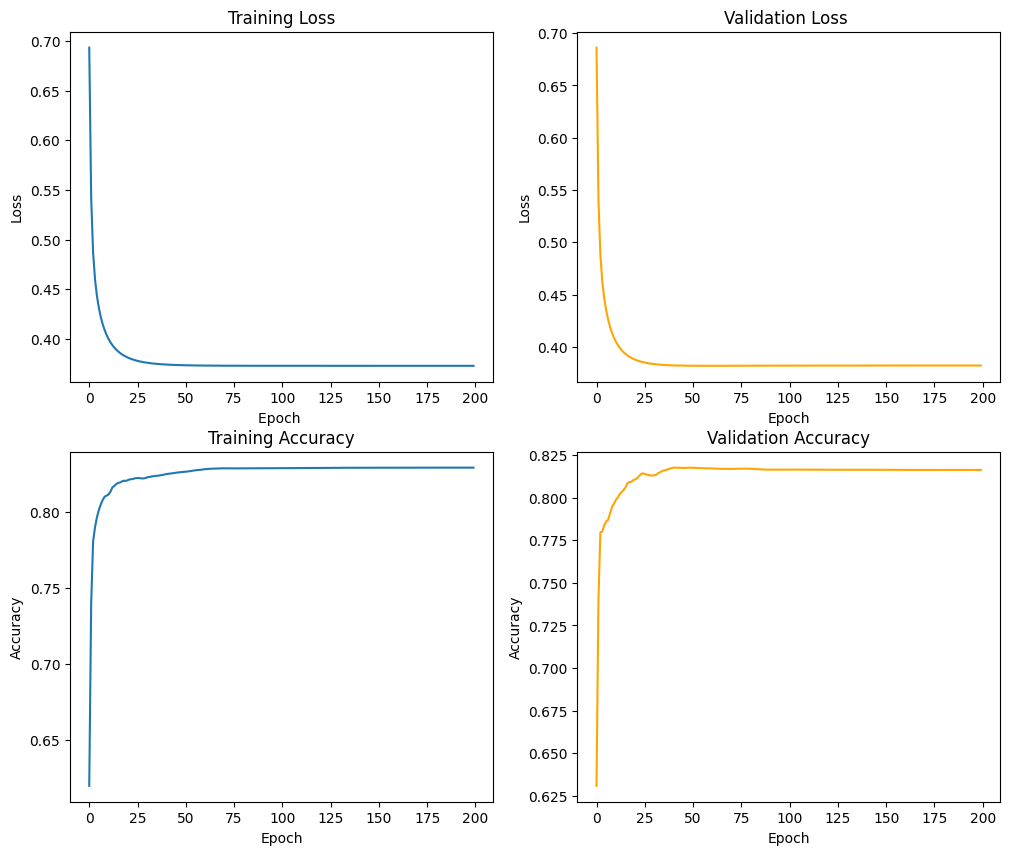

In [21]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch ', ylabel ='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss ')

ax[1, 0].plot(train_accuracy)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accuracy, 'orange')
ax[1, 1].set(xlabel ='Epoch', ylabel ='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [22]:
val_set_acc = compute_accuracy(x_val, y_val, theta)
test_set_acc = compute_accuracy(x_test, y_test, theta)
print('Evaluation on validation and test set:')
print(f'Evaluation accuracy: {val_set_acc}')
print(f'Validation accuracy: {test_set_acc}')

Evaluation on validation and test set:
Evaluation accuracy: 0.8169191919191919
Validation accuracy: 0.833596214511041
